In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import scipy
import pickle

In [2]:
sys.path.append('../../source/')
sys.path.append('../Tang/')
from JungeUtilities import beta_hedging, portfolio_ize, date_to_int
from get_beta import get_beta
from energy_functions import correlation, sharpe, volatility
from Hedge import Hedge

In [3]:
def swap(market_symbols, year_symbols):
    """
    Randomly changes the symbols in a market. Can either grow or shrink the market by 1 asset.  
    
    Inputs:
    -------
    market_symbols: list of symbols that are in a market
    year_symbols:   list of all the possible symbols for a given year
    
    Output:
    -------
    symbols: list of symbols in the market after the random change.  
    
    """
    coin_flip = np.random.binomial(1, 0.5)
    
    if (coin_flip == 0) and len(market_symbols)>10: # Shrink the market by one asset
        
        # Pick a random list index and pop that symbol off
        market_symbols.pop(np.random.randint(len(market_symbols)))
        return market_symbols
    
    else: # Grow the market by one asset
        
        # Get a list of the symbols for that year that are not already in the portfolio
        potential_symbols = list(set(year_symbols) - set(market_symbols))
        symbol_to_add = np.random.choice(potential_symbols)
        market_symbols.append(symbol_to_add)
        return market_symbols

In [10]:
def simulated_annealing(hedge, init_temp, min_temp, cool_by, reanneal, num_iter, energy_func):
    """
    Inputs:
    -------
    hedge: 
        hedge object that already has an instantiated market and portfolio. 
    init_temp: 
        float that controls the initial temperature of the algorithm
    min_temp: 
        float that acts as a floor for the decreasing temperature.  When this is hit, we heat back up to init_temp.  
    cool_by: 
        float that controls the speed that the cooling occurs
    reanneal: 
        integer that controls how many iterations pass between cooling steps
    num_iter: 
        integer that controls the total number of iterations that the algorithm runs
    energy_func:
        function that determines the energy state, eg correlation, volatility, sharpe ratio
    
    Returns:
    --------
    states: 
        a history of the current energy state at each iteration
    best_market: 
        list of the symbols for the best hedging market found
    """

    
#     hedge.generateRandomMarket()
    
    portfolio_values = hedge.dollar_portfolio_sum
    portfolio_returns = hedge.dollar_portfolio_sum_ret
    
    market = list(hedge.market)
    market_values = hedge.dollar_market_sum
    market_returns = hedge.dollar_market_sum_ret
    
    spy_returns = hedge.spy.pct_change()[61:]
    
    # Get betas from portfolio returns and market returns.
    _, betas = get_beta(portfolio_returns, market_returns)
    
    # Perform beta hedging.
    hedged_returns = beta_hedging(pd.Series(betas, index=market_values[60:].index),\
                                  market_values[60:], portfolio_values[60:])
    hedged_returns = hedged_returns.values.reshape(hedged_returns.shape[0])

        
    # A running account of the best market found.  This is updated as better markets are found.       
    best_market_energy = energy_func(hedged_returns[1:], spy_returns[1:])
    best_market = hedge.market
    
    # Initial value for old_E is the initial total value of the starting point.
    old_E = best_market_energy
    
    temperature = init_temp
    
    # A history of the current state of the algorithm.
    states = np.zeros(num_iter)
    
    for i in range(num_iter):
        if i%10==0:
            print i
        
        # Switch the bag up a little bit and recalculate market values and returns.  
        market = list(hedge.market)
        hedge.market = swap(market, hedge.stockuniverse)
        
        market_values = hedge.dollar_market_sum
        market_returns = hedge.dollar_market_sum_ret
            
        # Get beta values from portfolio and market.
        _, betas = get_beta(portfolio_returns, market_returns)
        
        # Perform beta hedging.
        hedged_returns = beta_hedging(pd.Series(betas, index=market_values[60:].index), \
                                          market_values[60:], portfolio_values[60:])
        hedged_returns = hedged_returns.values.reshape(hedged_returns.shape[0])

        # Examine energy state of the new bag.
        new_E = energy_func(hedged_returns[1:], spy_returns[1:])
        
        delta_E = new_E - old_E
        
        # We always accept an improvement.
        if new_E < old_E:
            #market = proposed_market
            states[i] = new_E
            old_E = new_E
            # Update our running best bag found.
            if new_E > best_market_energy:
                best_market_energy = new_E
                best_market = market
        # We sometimes accept a decline because this can get us out of a local minimum.
        elif np.random.rand() < np.exp(-delta_E / temperature):
            #market = proposed_proposed
            states[i] = new_E
            old_E = new_E

        # And sometimes we just stay where we are until something better comes along.
        else: 
            states[i] = old_E
            # Put the old market back in
            hedge.market = market
            
        # Cool down slowly at the defined interval.
        if num_iter % reanneal == 0:
            temperature = temperature * cool_by
            
            # Reheat when the temperature gets too cold.
            if temperature < min_temp:
                temperature = init_temp
    
    hedge.market = best_market
    return states, best_market

In [11]:
hedge = Hedge(begindate='2014-01-01', enddate='2014-12-31')
hedge.portfolio = ['FLIR', 'IVC', 'KNDI', 'MHO', 'EVC', 'PCO', 'COWN', 'NILE', 'MIW',
       'ANAC', 'ADHD', 'PLBC', 'ESXB', 'JRO', 'WES', 'HURC', 'MQT', 'EROS',
       'RPAI', 'HMNF']
hedge.market = ['GPX', 'GRMN', 'MPWR', 'ENR', 'CTHR', 'PRFZ', 'SUMR', 'CUBE',
       'ACTS', 'ANF', 'MYI', 'SON', 'SSL', 'PW', 'KT', 'TWN', 'IPWR',
       'AAN', 'CASH', 'DISCA', 'RFP', 'HPS', 'WMB', 'VRSN', 'ETN', 'WPZ',
       'RAI', 'BOXC', 'ARCI', 'EMN', 'LMOS', 'EXPD', 'NQS', 'GB', 'KNOP',
       'CNL', 'ENDP', 'SPSC', 'SCVL', 'EPAY']


st, bm = simulated_annealing(hedge, init_temp=1, min_temp=0.01, cool_by=0.99, reanneal=100, num_iter=10000, \
                    energy_func=correlation)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [12]:
print "Number of assets in market at the end:", len(hedge.market)

Number of assets in market at the end: 38


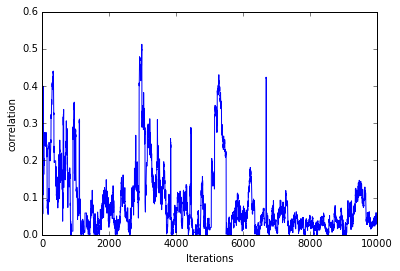

In [24]:
plt.plot(st)
plt.xlabel("Iterations")
plt.ylabel("correlation")

## Results

In [15]:
_,betas = get_beta(hedge.dollar_portfolio_sum_ret, hedge.dollar_market_sum_ret)

hedged_returns_dollars = beta_hedging(pd.Series(betas, index=hedge.dollar_market_sum[60:].index), \
                                          hedge.dollar_market_sum[60:], hedge.dollar_portfolio_sum[60:])
hedged_returns_dollars = hedged_returns_dollars.values.reshape(hedged_returns_dollars.shape[0])

p = hedged_returns_dollars[1:]
m = hedge.spy.pct_change()[61:][1:]
print "Absolute Value of Correlation with S&P:", correlation(p,m)
print "Volatility:", volatility(p,m)
print "Sharpe Ratio:", -sharpe(p,m)
print "Relative Return:", 100*(np.sum(hedged_returns_dollars[1:])/1000.), "%"
print "S&P Return", (hedge.spy[-1]-hedge.spy[0])/hedge.spy[0]*100, "%"

Absolute Value of Correlation with S&P: 0.495715901342
Volatility: 10.2899426224
Sharpe Ratio: 0.0494559812585
Relative Return: 9.66908498016 %
S&P Return 12.3865939845 %


## Baseline

In [16]:
_,betas = get_beta(hedge.dollar_portfolio_sum_ret, hedge.spy)

hedged_returns_dollars = beta_hedging(pd.Series(betas, index=hedge.dollar_market_sum[60:].index), \
                                          hedge.spy[60:], hedge.dollar_portfolio_sum[60:])
hedged_returns_dollars = hedged_returns_dollars.values.reshape(hedged_returns_dollars.shape[0])

p = hedged_returns_dollars[1:]
m = hedge.spy.pct_change()[61:][1:]
print "Absolute Value of Correlation with S&P:", correlation(p,m)
print "Volatility:", volatility(p,m)
print "Sharpe Ratio:", -sharpe(p,m)
print "Relative Return:", 100*(np.sum(hedged_returns_dollars[1:])/1000.), "%"
print "S&P Return", (hedge.spy[-1]-hedge.spy[0])/hedge.spy[0]*100, "%"

Absolute Value of Correlation with S&P: 0.673705647743
Volatility: 10.0105301549
Sharpe Ratio: 0.0278680503298
Relative Return: 5.3005052055 %
S&P Return 12.3865939845 %


In [19]:
print "Unhedged Portfolio Volatility:", volatility(hedge.dollar_portfolio_sum_ret)
print "S&P Sharpe:", -sharpe(hedge.spy)


Unhedged Portfolio Volatility: 0.00977551336706
S&P Sharpe: 24.1980547846


In [22]:
hedged_returns_dollars



array([         nan,  -1.62473439, -16.45003832, -20.71248368,
       -15.36318548,   5.97615375,  12.36062979, -26.89366699,
        -5.94193106,  -2.04587726,  -5.75143418,   7.4263123 ,
         3.64821018,  16.84805361,  21.92592367,  -9.29493861,
        -0.59556848, -16.86090251,  -9.29483058,   6.95675575,
         0.35356116,   7.69025165,  -4.36190894,   3.17964143,
       -13.50676591,  -5.40366256,  -5.08139767,   2.17853009,
        26.87406554, -14.49844677,  -3.66287268,  -5.94991682,
         3.07858948,   1.41601185,  -9.84812104,   5.39499775,
         3.78428949,  10.88738426,   8.88803837,  -0.86397514,
         4.37799663,  -6.94359511,   0.3987094 ,  -5.00246008,
         1.42952497,  11.4117982 ,  10.82178667,   6.43850443,
         0.61960085,  -1.09247943,  -8.89430261,  -0.09569065,
         3.23339833,   9.80681302,  -1.62235772,  -3.09039528,
         3.30790675,  -3.51886211,  -2.4505777 ,   9.00521597,
        -4.25165369,   8.83680603,   4.46965025,   8.47